In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import zipfile
import requests
import io
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection

In [2]:
facebook = pd.read_csv(
    # Dataset from the SNAP database
    "https://snap.stanford.edu/data/facebook_combined.txt.gz",
    compression="gzip",
    sep=" ",
    names=["start_node", "end_node"],
)
G_facebook = nx.from_pandas_edgelist(facebook, "start_node", "end_node")

In [3]:
arxiv = pd.read_csv(
    # Dataset from the SNAP database
    "https://snap.stanford.edu/data/ca-GrQc.txt.gz",
    compression="gzip",
    sep="\t",
    comment='#',
    header=None,
    names=["start_node", "end_node"],
)
G_arxiv = nx.from_pandas_edgelist(arxiv, "start_node", "end_node")

In [4]:
patents = pd.read_csv(
    # Dataset from the SNAP database
    "https://snap.stanford.edu/data/cit-Patents.txt.gz",
    compression="gzip",
    sep="\t",
    comment='#',
    header=None,
    names=["start_node", "end_node"],
)
G_patents = nx.from_pandas_edgelist(patents, "start_node", "end_node")

In [5]:
internet = pd.read_csv(
    # Dataset from the SNAP database
    "https://snap.stanford.edu/data/as-733.tar.gz",
    compression="gzip",
    sep="\t",
    comment='#',
    header=None,
    names=["start_node", "end_node"],
)
G_internet = nx.from_pandas_edgelist(internet, "start_node", "end_node")

/tmp/ipykernel_25959/3726032165.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  internet = pd.read_csv(


# P8.1

In [6]:
def plot_clustering(G: nx.Graph):
    deg = {}
    clus = {}

    for u in tqdm(G.nodes()):
        nbrs = list(G[u])
        k = len(nbrs)
        deg[u] = k

        if k < 2:
            clus[u] = 0.0
        else:
            links = 0
            for i in range(k):
                for j in range(i + 1, k):
                    if nbrs[j] in G[nbrs[i]]:
                        links += 1
            clus[u] = 2.0 * links / (k * (k - 1))

    x = sorted([k for k in set(deg.values()) if k > 0])
    y = [np.mean([clus[n] for n in G if deg[n] == k]) for k in x]

    plt.loglog(x, y, 'bo-', label='C(k)')
    plt.loglog(x, [1 / k for k in x], 'r--', label='k^-1')
    plt.xlabel('Degree k')
    plt.ylabel('Clustering C(k)')
    plt.legend()
    plt.show()

# P8.2

100%|██████████| 16052/16052 [00:25<00:00, 637.07it/s]  


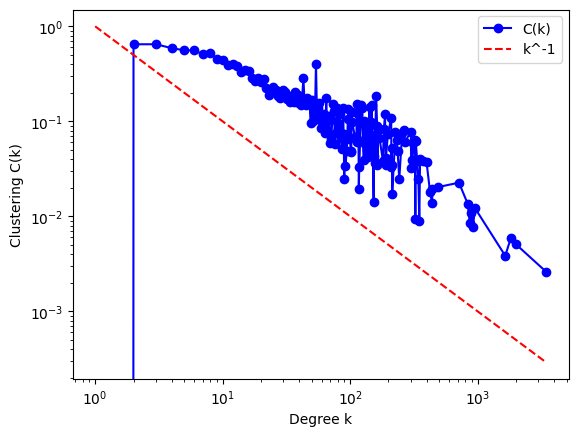

In [7]:
plot_clustering(G_internet)

100%|██████████| 3774768/3774768 [09:51<00:00, 6380.51it/s] 


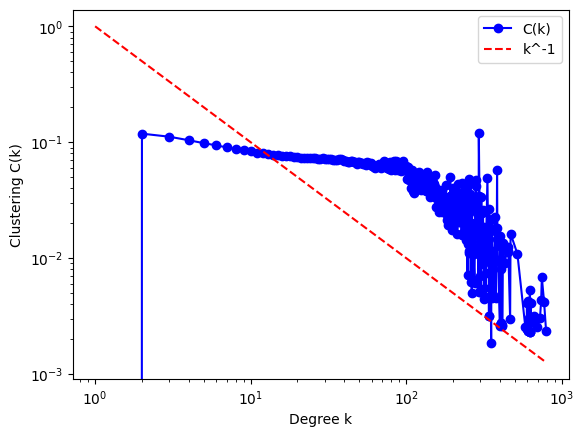

In [8]:
plot_clustering(G_patents)

100%|██████████| 5242/5242 [00:00<00:00, 16142.91it/s]


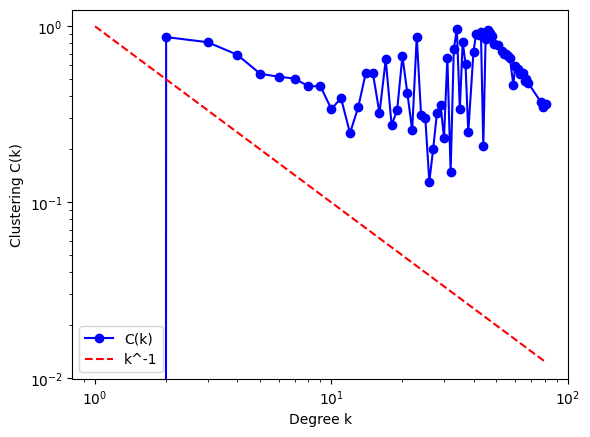

In [9]:
plot_clustering(G_arxiv)

100%|██████████| 4039/4039 [00:13<00:00, 288.71it/s]


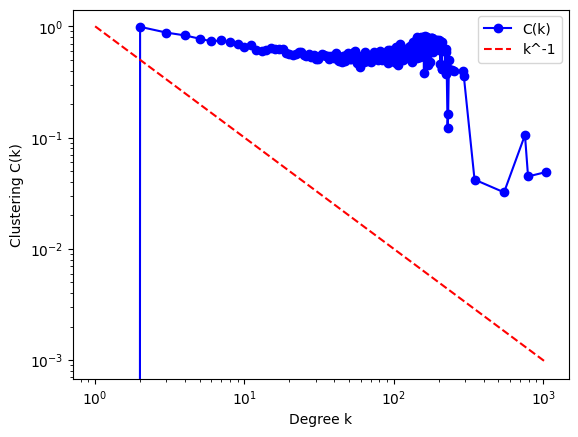

In [10]:
plot_clustering(G_facebook)

# P8.3

https://gtfs.org/getting-started/features/base/#

In [11]:
gtfs_url = 'https://gtfs.ztm.waw.pl/last'

with zipfile.ZipFile(io.BytesIO(requests.get(gtfs_url).content)) as z:
    stops = pd.read_csv(z.open('stops.txt'), dtype={'stop_id': str})
    routes = pd.read_csv(z.open('routes.txt'), dtype={'route_id': str})
    trips = pd.read_csv(z.open('trips.txt'), dtype={'route_id': str, 'trip_id': str})
    stop_times = pd.read_csv(z.open('stop_times.txt'), dtype={'trip_id': str, 'stop_id': str},
                             usecols=['trip_id', 'stop_id', 'stop_sequence', 'arrival_time', 'departure_time'])

In [12]:
df = stop_times.merge(trips[['trip_id', 'route_id']], on='trip_id')
df = df.merge(routes[['route_id', 'route_type']], on='route_id')
df = df.sort_values(['trip_id', 'stop_sequence']).drop_duplicates(['route_id', 'stop_sequence'])
df['next'] = df.groupby('trip_id')['stop_id'].shift(-1)
df = df.dropna(subset=['next'])

type_map = {0: 'Tram', 2: 'Rail', 3: 'Bus'}
graphs = {}

for r_type, name in type_map.items():
    graphs[name] = nx.from_pandas_edgelist(
        df[df.route_type == r_type],
        source='stop_id',
        target='next',
        create_using=nx.DiGraph
    )

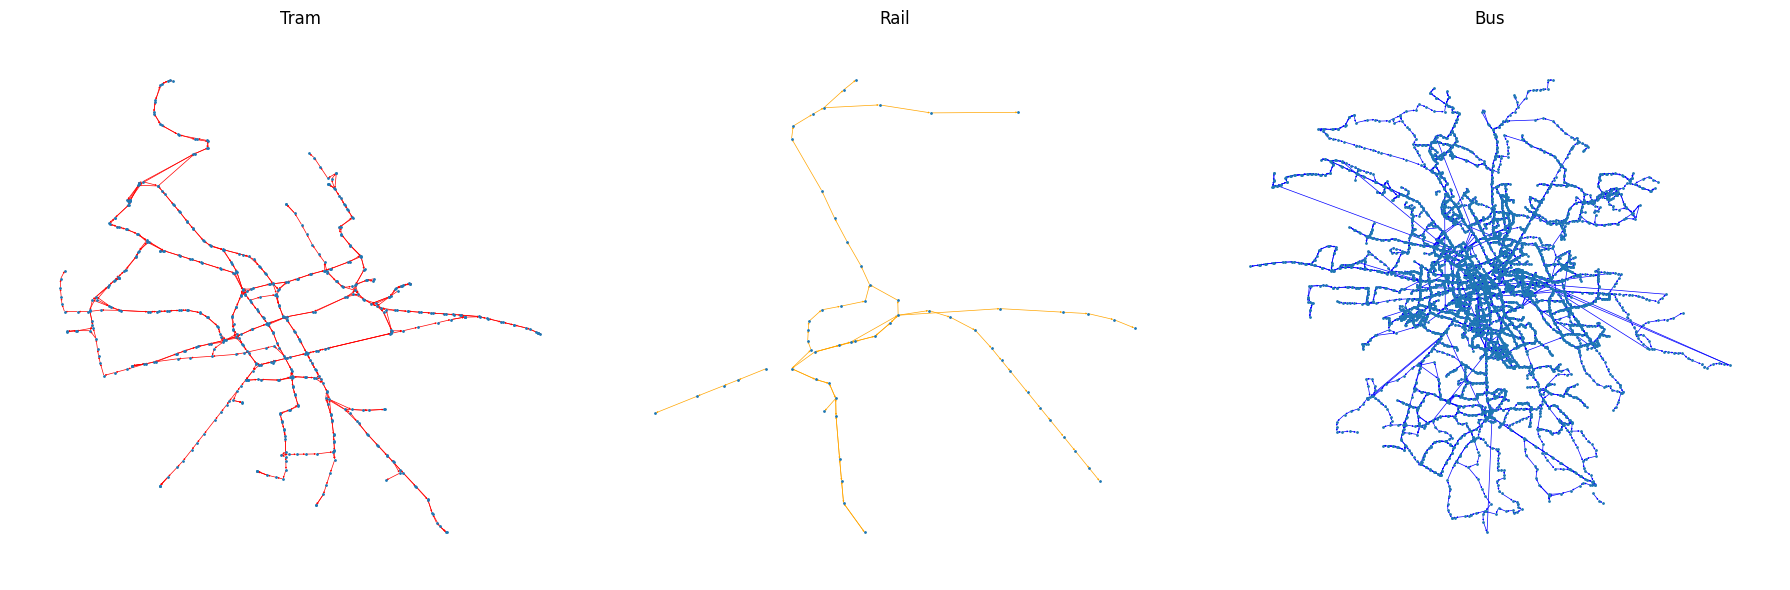

In [13]:
pos = dict(zip(stops.stop_id, zip(stops.stop_lon, stops.stop_lat)))
colors = {'Tram': 'red', 'Rail': 'orange', 'Bus': 'blue'}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (name, G) in zip(axes, graphs.items()):
    if len(G) > 0:
        nx.draw(G, pos, ax=ax, node_size=1, edge_color=colors[name], width=0.5, arrowsize=2)
    ax.set_title(name)

plt.tight_layout()
plt.show()

# P8.4

In [14]:
all_graphs = list(graphs.items()) + [('Combined', nx.compose_all(graphs.values()))]
stats = []

for name, G in all_graphs:
    n, e = G.number_of_nodes(), G.number_of_edges()
    stats.append({
        'Layer': name,
        'Nodes': n,
        'Edges': e,
        '<k>': round((2 * e) / n, 4) if n > 0 else 0,
        'Density': f"{nx.density(G):.6f}"
    })

print(pd.DataFrame(stats))

      Layer  Nodes  Edges     <k>   Density
0      Tram    529    587  2.2193  0.002102
1      Rail     62     75  2.4194  0.019831
2       Bus   5147   6239  2.4243  0.000236
3  Combined   5725   6895  2.4087  0.000210


# P8.6

In [15]:
df = stop_times.merge(trips[['trip_id', 'route_id']].merge(routes[['route_id', 'route_type']], on='route_id'), on='trip_id')

# Sort and Shift to find next nodes
df = df.sort_values(['trip_id', 'stop_sequence'])
df[['next_node', 'arr_next', 'next_trip']] = df[['stop_id', 'arrival_time', 'trip_id']].shift(-1)
df = df[df['trip_id'] == df['next_trip']].copy()

# Time conversion
def to_sec(s): return s.str[:2].astype(int) * 3600 + s.str[3:5].astype(int) * 60 + s.str[6:].astype(int)
df['dep_sec'], df['arr_sec'] = to_sec(df['departure_time']), to_sec(df['arr_next'])
df['duration'] = df['arr_sec'] - df['dep_sec']

# Build Graphs
temporal_graphs = {
    name: nx.from_pandas_edgelist(
        df[df['route_type'] == code], 'stop_id', 'next_node',
        edge_attr=['dep_sec', 'arr_sec', 'trip_id', 'duration'],
        create_using=nx.MultiDiGraph
    )
    for name, code in [('Tram', 0), ('Rail', 2), ('Bus', 3)]
}

# P8.7

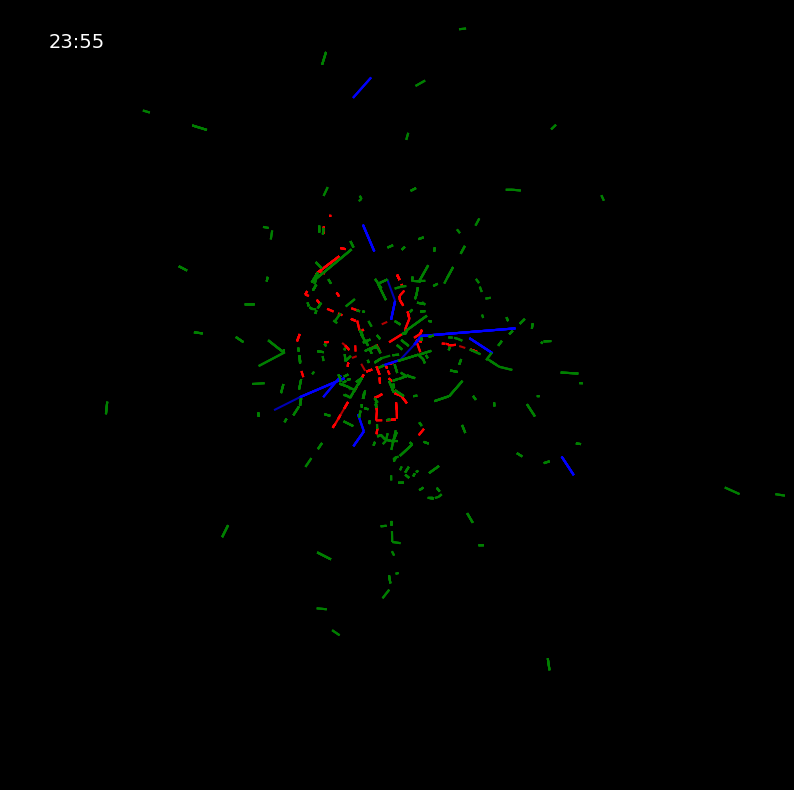

In [16]:
pos = {s.stop_id: (s.stop_lon, s.stop_lat) for s in stops.itertuples()}
cmap = {'Tram': 'red', 'Rail': 'blue', 'Bus': 'green'}

data = np.array([
    [d['dep_sec'], d['arr_sec'], pos[u], pos[v], cmap[m]]
    for m, G in temporal_graphs.items()
    for u, v, d in G.edges(data=True) if u in pos and v in pos
], dtype=object)

fig, ax = plt.subplots(figsize=(10, 10), facecolor='black')
ax.set_facecolor('black'); ax.axis('off')
coords = list(pos.values())
ax.set_xlim(min(c[0] for c in coords), max(c[0] for c in coords))
ax.set_ylim(min(c[1] for c in coords), max(c[1] for c in coords))

lc = LineCollection([], linewidths=1.5, alpha=0.7)
ax.add_collection(lc)
txt = ax.text(0.05, 0.95, '', transform=ax.transAxes, color='white', fontsize=14)

def update(t):
    active = data[(data[:, 0] <= t) & (data[:, 1] > t)]
    lc.set_segments(list(zip(active[:, 2], active[:, 3])))
    lc.set_color(active[:, 4] if len(active) else [])
    txt.set_text(f'{t//3600:02d}:{(t%3600)//60:02d}')
    return lc, txt

times = np.arange(4*3600, 24*3600, 300)
ani = FuncAnimation(fig, update, frames=times, interval=50, blit=True)
ani.save('warsaw_traffic.gif', writer='pillow', fps=15)
plt.show()

# P8.8

100%|██████████| 80/80 [04:20<00:00,  3.26s/it]


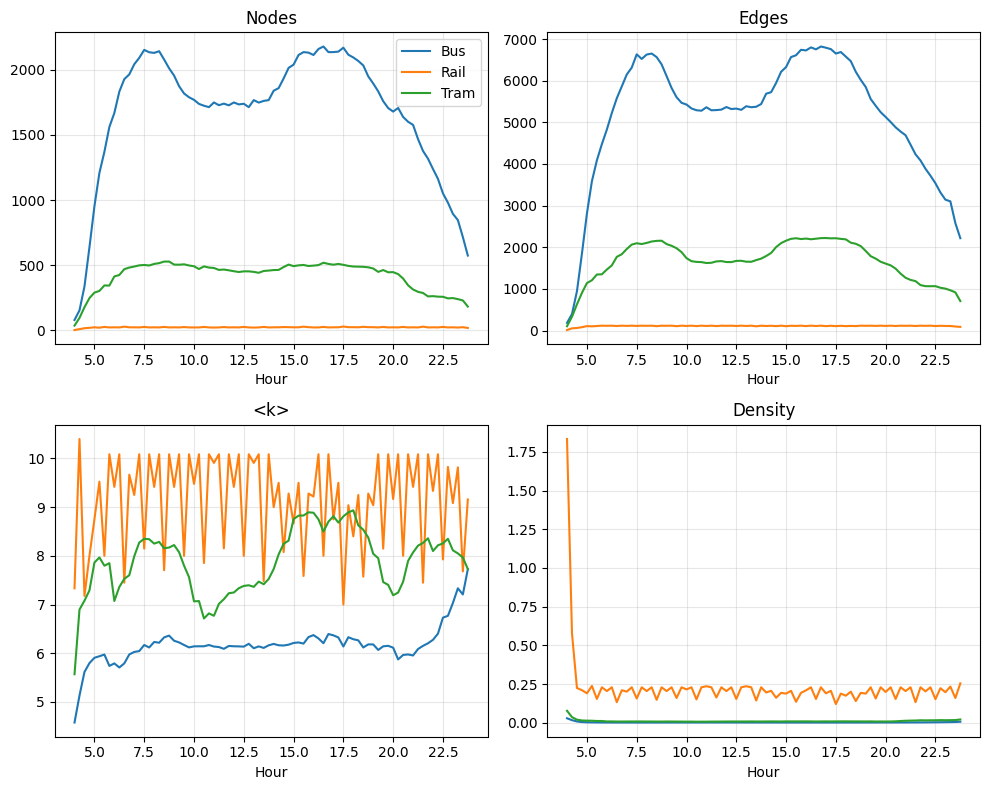

In [19]:
stats_data = []
for t in tqdm(range(4 * 3600, 24 * 3600, 900)):
    for name, G in temporal_graphs.items():
        active = [(u, v) for u, v, d in G.edges(data=True) if d['dep_sec'] <= t < d['arr_sec']]

        active_nodes = set(u for u, v in active) | set(v for u, v in active)
        n, e = len(active_nodes), len(active)

        stats_data.append({
            'Time': t/3600, 'Layer': name,
            'Nodes': n, 'Edges': e,
            '<k>': (2 * e) / n if n > 0 else 0,
            'Density': e / (n * (n - 1)) if n > 1 else 0
        })

df_stats = pd.DataFrame(stats_data)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for ax, metric in zip(axes.flatten(), ['Nodes', 'Edges', '<k>', 'Density']):
    for name, data in df_stats.groupby('Layer'):
        ax.plot(data['Time'], data[metric], label=name)
    ax.set_title(metric); ax.set_xlabel('Hour'); ax.grid(alpha=0.3)

axes[0,0].legend()
plt.tight_layout()
plt.show()